In [2]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ca_doi_external_appeals"
OUTPUT_DATA_DIR = "./output_data/ca_doi_external_appeals"  # Set to None if you don't want to save non-required data for external use

In [3]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [4]:
# DOI yearly report:
# https://www.insurance.ca.gov/0400-news/0200-studies-reports/0700-commissioner-report/upload/2021Annual-Report-of-the-Insurance-Commissioner.pdf

# DMHC yearly report
# https://dmhc.ca.gov/AbouttheDMHC/DMHCReports/AnnualReports.aspx

# HHS page for IMR determinations from Department of Managed Health Care (applies to HMO IMR appeals)
# https://data.chhs.ca.gov/dataset/independent-medical-review-imr-determinations-trend

# CA DOI, same data for decisions sent to CA department of Insurance.
# Different format, why god :0
# https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:1:1847478466984:::::

### DOI Data

In [7]:
url = "https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:4:15780617087096:CSV:NO:RP::"
doi_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_doi_imr.csv")
download_file_from_url(url, doi_imr_data_path, legacy_ssl=True)

Target file ./input_data/ca_doi_imr.csv already exists.


In [9]:
df = pd.read_csv(doi_imr_data_path, encoding="ISO-8859-1").sort_values(
    by="Year", ignore_index=True
)

In [11]:
print(f"This dataset contains a total of {len(df)} IMRs administered by CDI.")
for year, count in df["Year"].value_counts(sort=False).items():
    print(f"\t{count} IMRs from {year}")

This dataset contains a total of 4719 IMRs administered by CDI.
	384 IMRs from 2011
	472 IMRs from 2012
	488 IMRs from 2013
	455 IMRs from 2014
	473 IMRs from 2015
	453 IMRs from 2016
	440 IMRs from 2017
	400 IMRs from 2018
	375 IMRs from 2019
	274 IMRs from 2020
	192 IMRs from 2021
	197 IMRs from 2022
	116 IMRs from 2023


In [17]:
# # Remove 2023 records, since claims are still being adjudicated, there are pending internal appeals, etc.
# Yields view of statistics that is inconsistent with methodology for complete years
df = df[df["Year"] != 2023]

In [18]:
def get_overturn_rates_by_category(
    df: pd.DataFrame,
    cat_col: str,
    by_year: bool = False,
    outcome_col: str = "Outcome",
    upheld_cat_name: str = "Insurer Denial Upheld",
    overturned_cat_name: str = "Insurer Denial Overturned",
    year_cat_name: str = "Year",
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df[outcome_col].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get(overturned_cat_name, 0)
        decision_data[val]["overall"]["overturned"] = overturned
        decision_data[val]["overall"]["upheld"] = overturn_counts.get(
            upheld_cat_name, 0
        )
        decision_data[val]["overall"]["withdrew"] = overturn_counts.get(
            "Insured Withdrew", 0
        )
        decision_data[val]["overall"]["overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df[year_cat_name].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df[year_cat_name] == year]
                overturn_counts = sub_df[outcome_col].value_counts()
                overturned = overturn_counts.get(overturned_cat_name, 0)
                decision_data[val][year]["upheld"] = overturn_counts.get(
                    upheld_cat_name, 0
                )
                decision_data[val][year]["overturned"] = overturned
                decision_data[val][year]["withdrew"] = overturn_counts.get(
                    "Insured Withdrew", None
                )
                decision_data[val][year]["overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data

In [19]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were overturned."
    )
    return None

In [20]:
appeal_decision_counts = df["Outcome"].value_counts()
print_appeal_results(appeal_decision_counts)

['Insurer Denial Upheld', 'Insurer Denial Overturned', 'Insured Withdrew']
50% of all original determinations in external appeals were upheld
49% of all original determinations in external appeals were overturned.


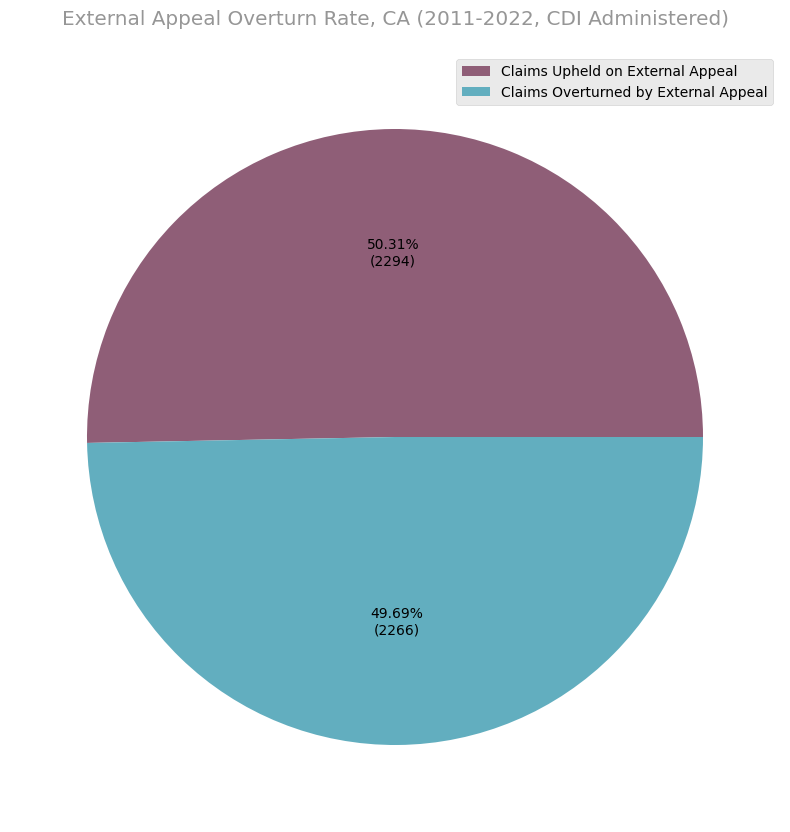

In [21]:
claims_externally_appealed = (
    appeal_decision_counts["Insurer Denial Upheld"]
    + appeal_decision_counts["Insurer Denial Overturned"]
)
claims_externally_overturned = appeal_decision_counts["Insurer Denial Overturned"]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Overturn Rate, CA (2011-2022, CDI Administered)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

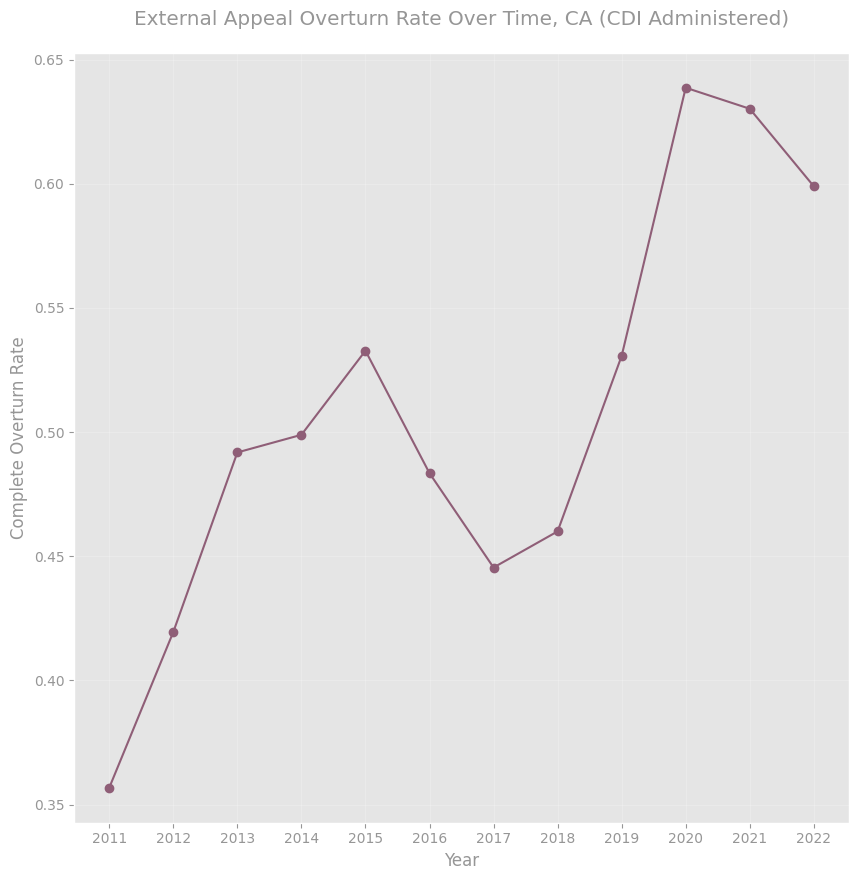

In [23]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, "Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeal Overturn Rate Over Time, CA (CDI Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

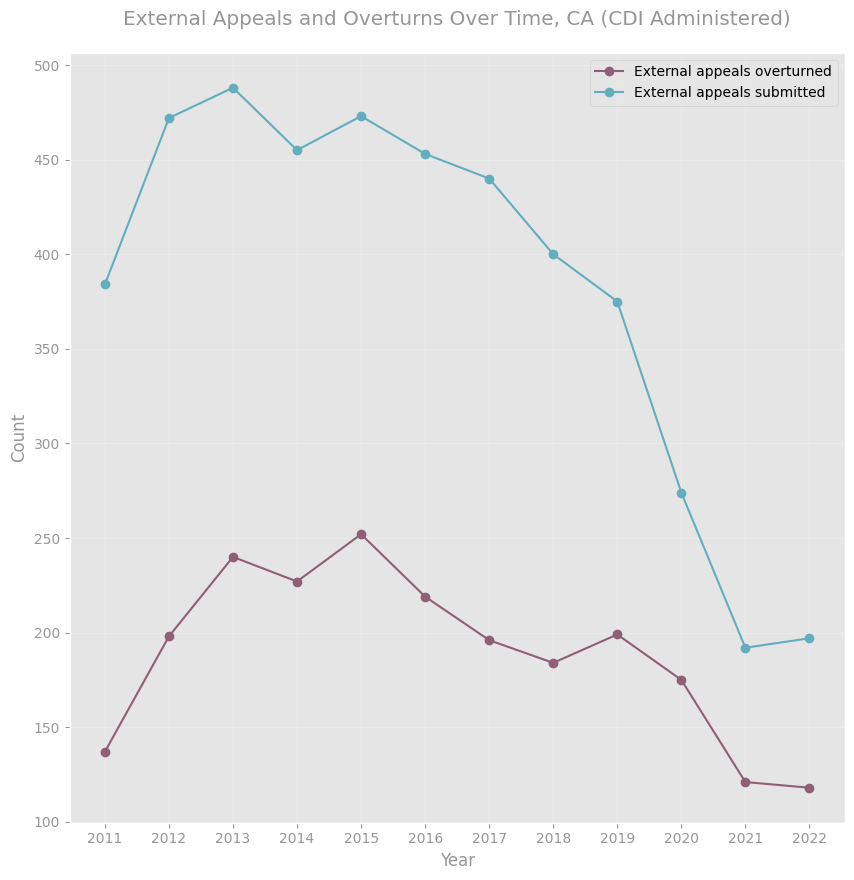

In [24]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeals and Overturns Over Time, CA (CDI Administered)")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

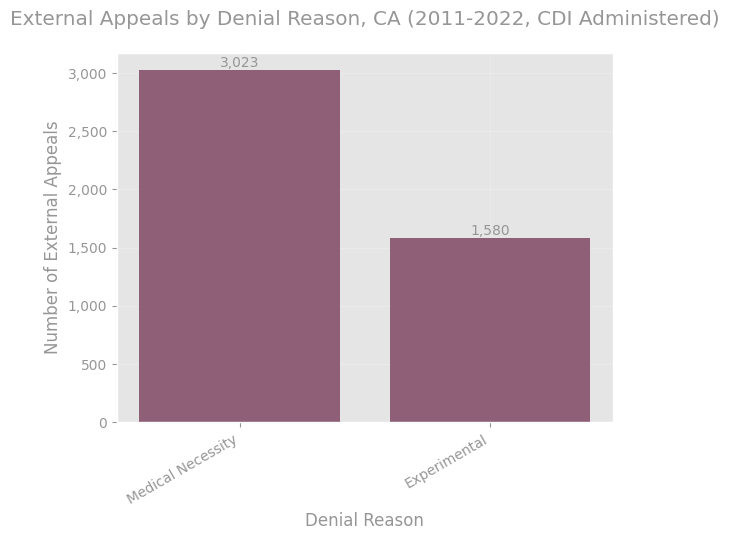

In [27]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Reason, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df["IMR Type"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
)

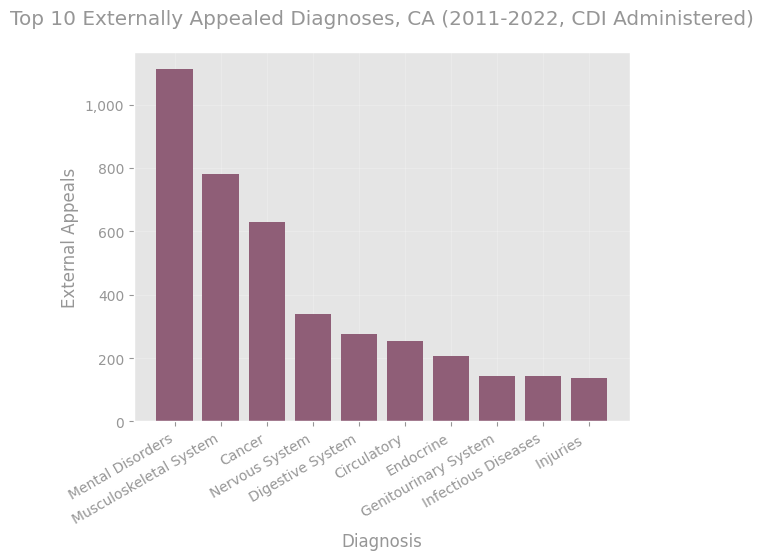

In [28]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses, CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
)

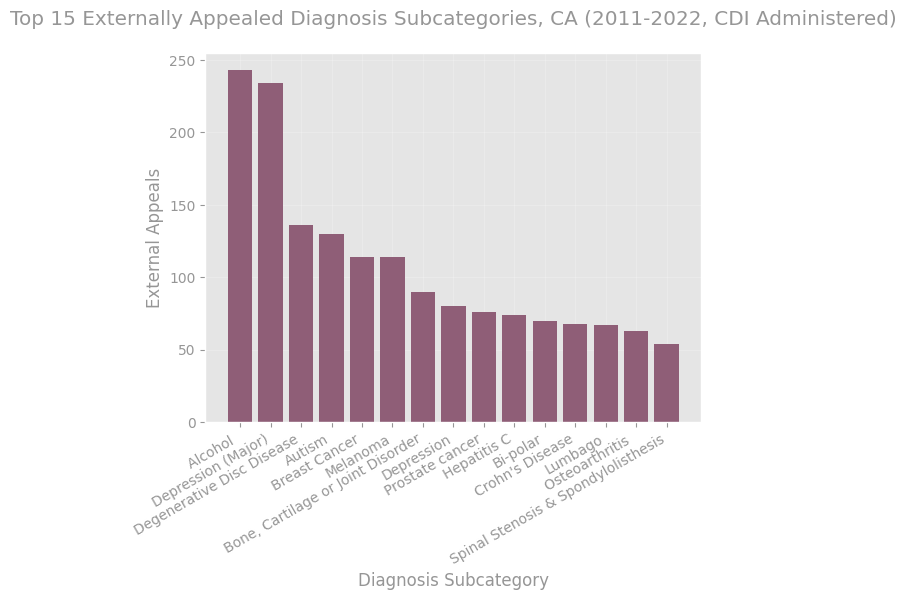

In [29]:
# Diagnosis breakdowns
n = 15
title = f"Top {n} Externally Appealed Diagnosis Subcategories, CA (2011-2022, CDI Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df["Diagnosis Subcategory"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(subdiagnosis_val_counts.index)
], subdiagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
)

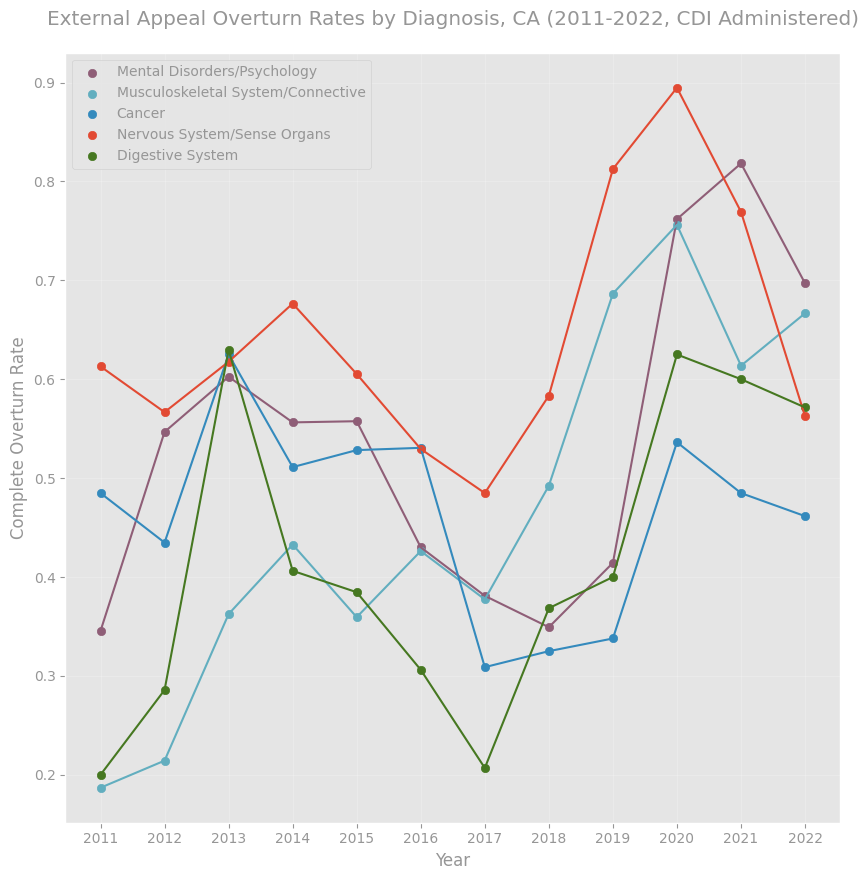

In [31]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title(
    "External Appeal Overturn Rates by Diagnosis, CA (2011-2022, CDI Administered)"
)
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

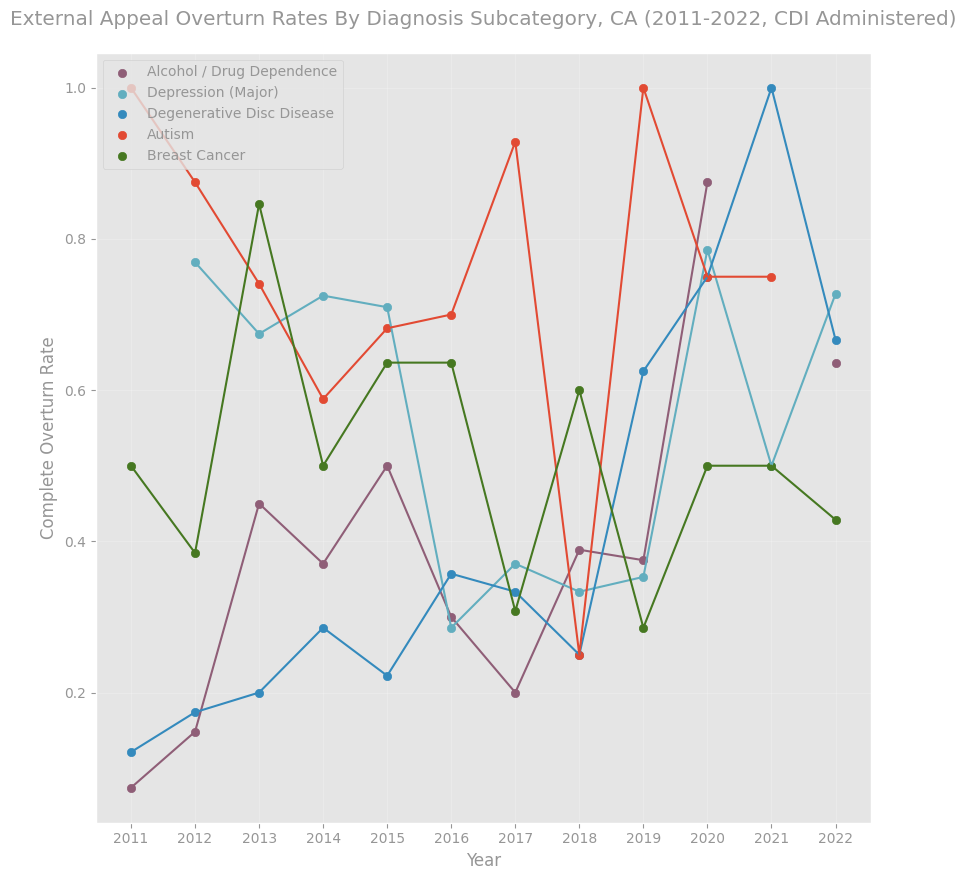

In [32]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis Subcategory", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title(
    "External Appeal Overturn Rates By Diagnosis Subcategory, CA (2011-2022, CDI Administered)"
)
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in subdiagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis_subcategory.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

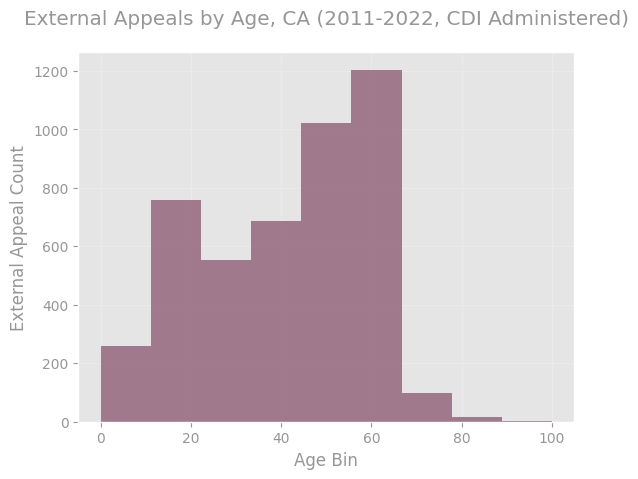

In [33]:
appeal_ages = df[df["Age"] != "-"]["Age"].astype(int)
title = "External Appeals by Age, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
bins = np.linspace(0, 100, 10)
plot_hist(
    appeal_ages,
    bins=bins,
    title=title,
    y_label="External Appeal Count",
    x_label="Age Bin",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)

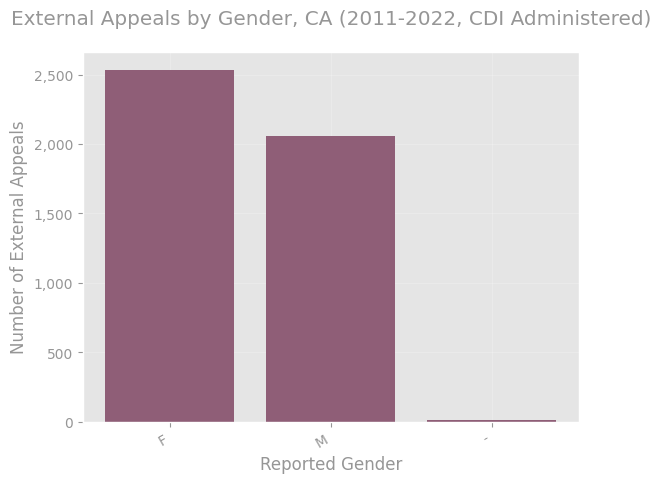

In [34]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeals by Gender, CA (2011-2022, CDI Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)

### DMHC Appeals

In [35]:
OUTPUT_IMAGE_DIR = "./images/ca_dmhc_external_appeals"
OUTPUT_DATA_DIR = "./output_data/ca_dmhc_external_appeals"  # Set to None if you don't want to save non-required data for external use
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [36]:
url = "https://data.chhs.ca.gov/dataset/b79b3447-4c10-4ae6-84e2-1076f83bb24e/resource/3340c5d7-4054-4d03-90e0-5f44290ed095/download/independent-medical-review-imr-determinations-trends.csv"
dmhc_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_dmhc.csv")
download_file_from_url(url, dmhc_imr_data_path)

Success.


In [45]:
df = pd.read_csv(dmhc_imr_data_path, encoding="latin1").sort_values(
    by="ReportYear", ignore_index=True
)

In [46]:
print(f"This dataset contains a total of {len(df)} IMRs administered by DMHC.")
for year, count in df["ReportYear"].value_counts(sort=False).items():
    print(f"\t{count} IMRs from {year}")

# # Remove 2023 records, since claims are still being adjudicated, there are pending internal appeals, etc.
# Yields view of statistics that is inconsistent with methodology for complete years
df = df[df["ReportYear"] != 2023]

This dataset contains a total of 34615 IMRs administered by DMHC.
	28 IMRs from 2001
	689 IMRs from 2002
	731 IMRs from 2003
	787 IMRs from 2004
	959 IMRs from 2005
	1080 IMRs from 2006
	1342 IMRs from 2007
	1520 IMRs from 2008
	1429 IMRs from 2009
	1452 IMRs from 2010
	1435 IMRs from 2011
	1200 IMRs from 2012
	1195 IMRs from 2013
	1432 IMRs from 2014
	2076 IMRs from 2015
	3053 IMRs from 2016
	2953 IMRs from 2017
	2683 IMRs from 2018
	2331 IMRs from 2019
	2197 IMRs from 2020
	2132 IMRs from 2021
	1769 IMRs from 2022
	142 IMRs from 2023


In [47]:
appeal_decision_counts = df["Determination"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld Decision of Health Plan', 'Overturned Decision of Health Plan']
51% of all original determinations in external appeals were upheld
49% of all original determinations in external appeals were overturned.


In [48]:
uphold_cat_name = "Upheld Decision of Health Plan"
overturn_cat_name = "Overturned Decision of Health Plan"
year_cat_name = "ReportYear"
denial_type_cat_name = "Type"
diagnosis_cat_name = "DiagnosisCategory"
diagnosis_subcat_name = "DiagnosisSubCategory"

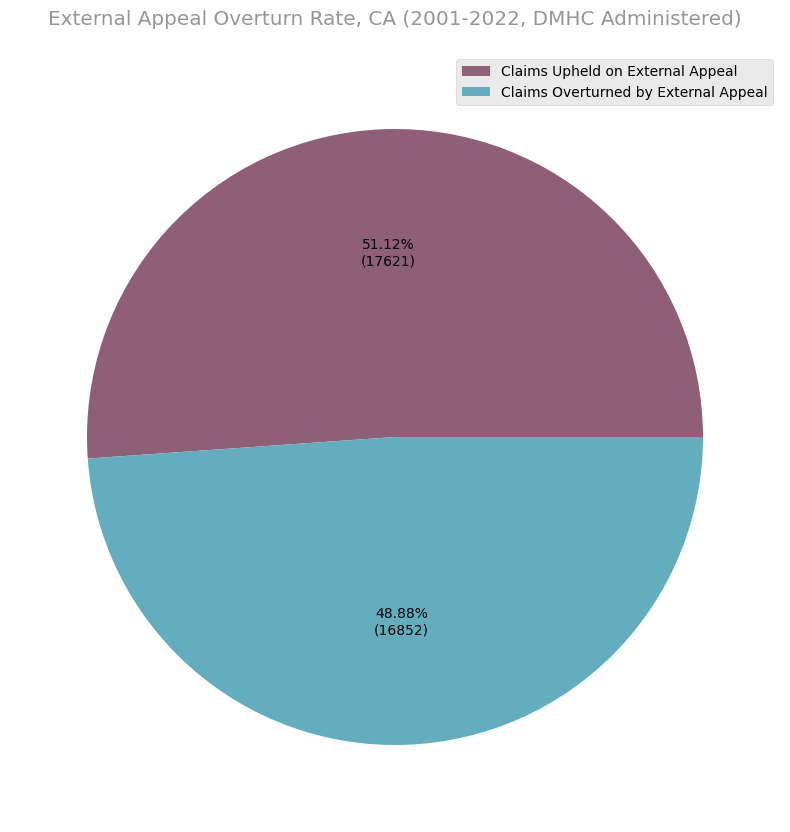

In [49]:
claims_externally_appealed = (
    appeal_decision_counts[uphold_cat_name] + appeal_decision_counts[overturn_cat_name]
)
claims_externally_overturned = appeal_decision_counts[overturn_cat_name]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Overturn Rate, CA (2001-2022, DMHC Administered)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

/tmp/ipykernel_20030/1928516476.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


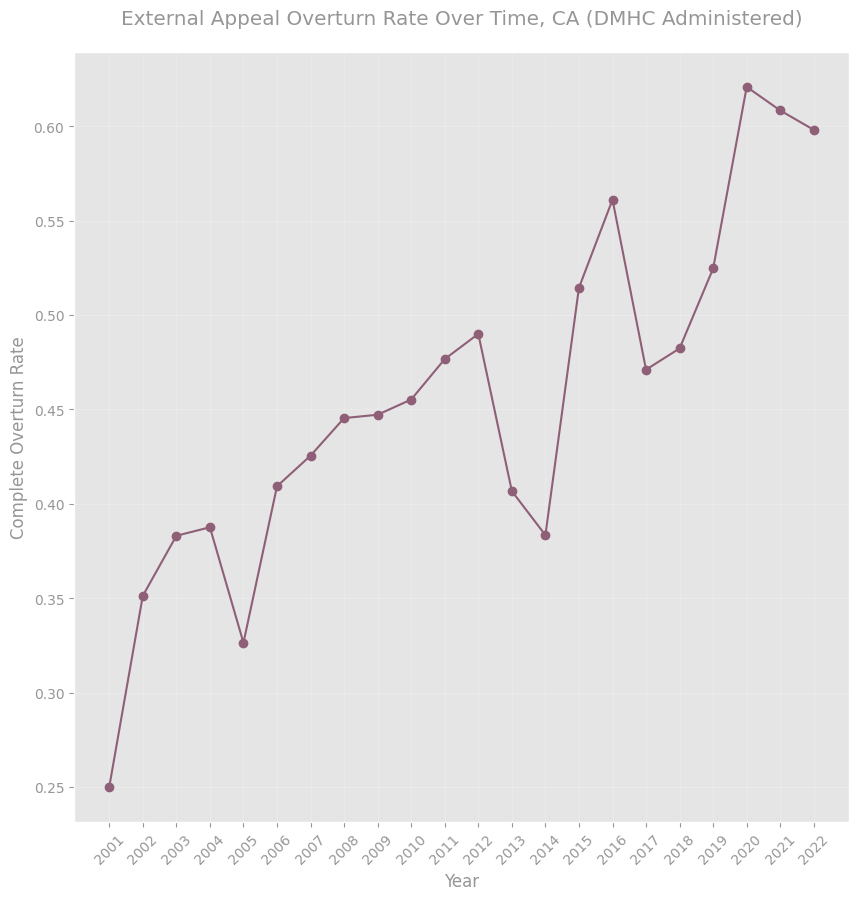

In [50]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(
    df,
    year_cat_name,
    outcome_col="Determination",
    upheld_cat_name=uphold_cat_name,
    overturned_cat_name=overturn_cat_name,
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
ax.set_title("External Appeal Overturn Rate Over Time, CA (DMHC Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
ax.set_xticklabels(dates, rotation=45)
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

/tmp/ipykernel_20030/3282574069.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


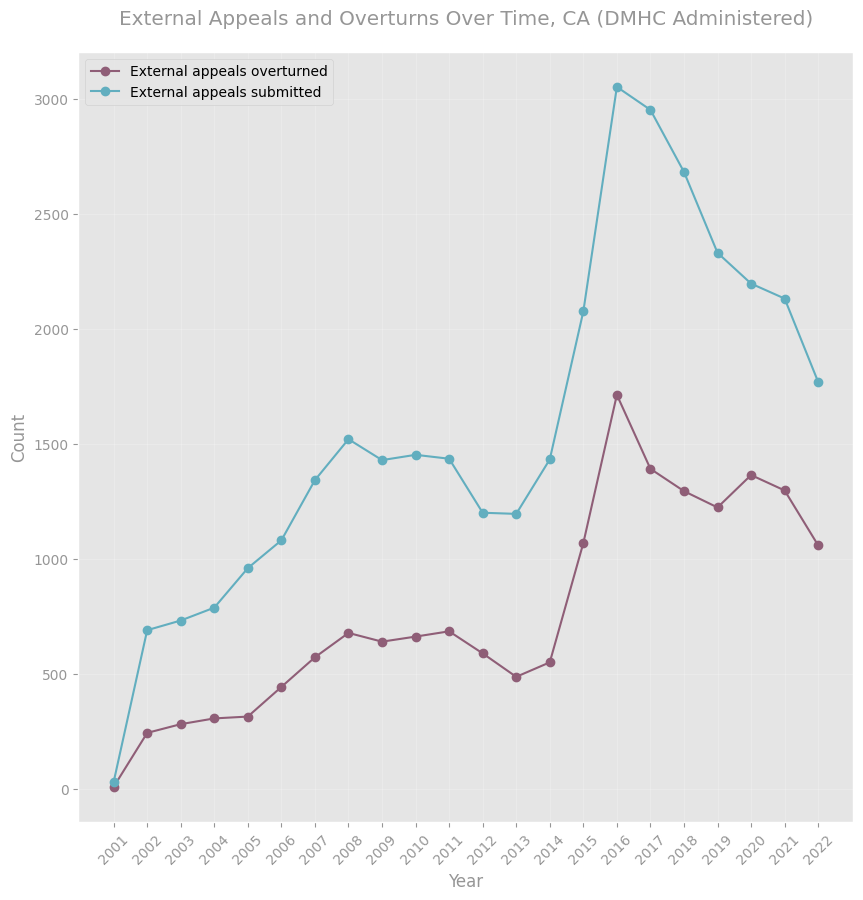

In [52]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
ax.set_title("External Appeals and Overturns Over Time, CA (DMHC Administered)")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.set_xticklabels(dates, rotation=45)
ax.legend(labelcolor="black", loc="upper left")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

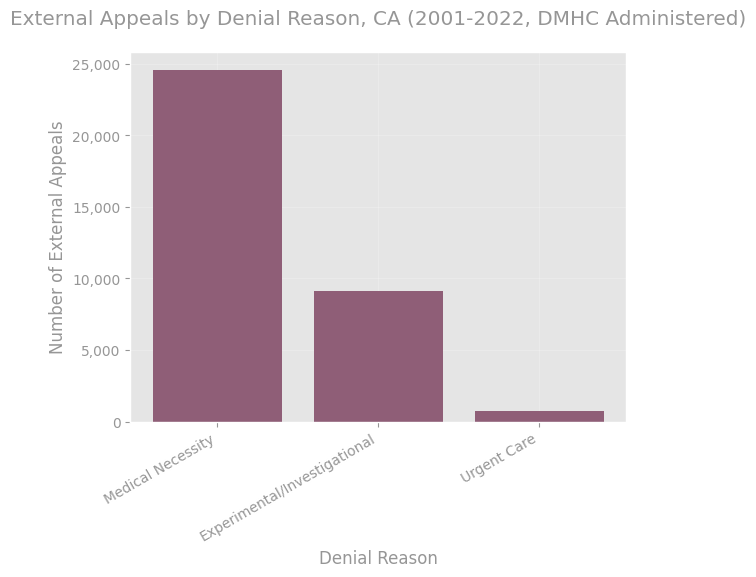

In [53]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Reason, CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df[denial_type_cat_name].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
)

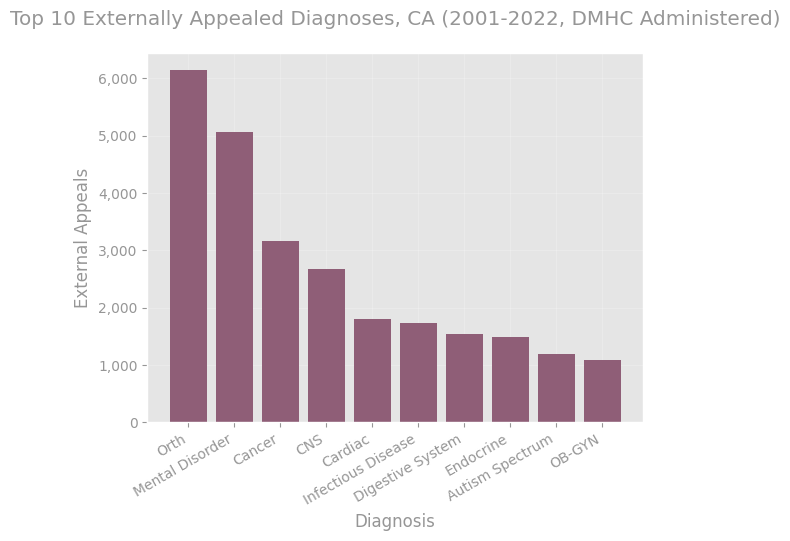

In [54]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses, CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df[diagnosis_cat_name].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
)

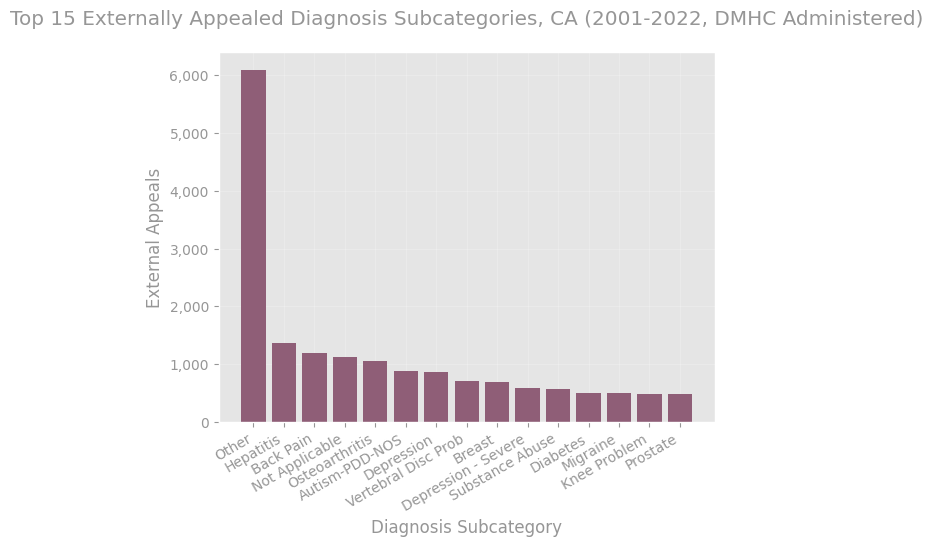

In [55]:
# Diagnosis breakdowns
n = 15
title = f"Top {n} Externally Appealed Diagnosis Subcategories, CA (2001-2022, DMHC Administered)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df[diagnosis_subcat_name].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(subdiagnosis_val_counts.index)
], subdiagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
)

/tmp/ipykernel_20030/618601945.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=45)


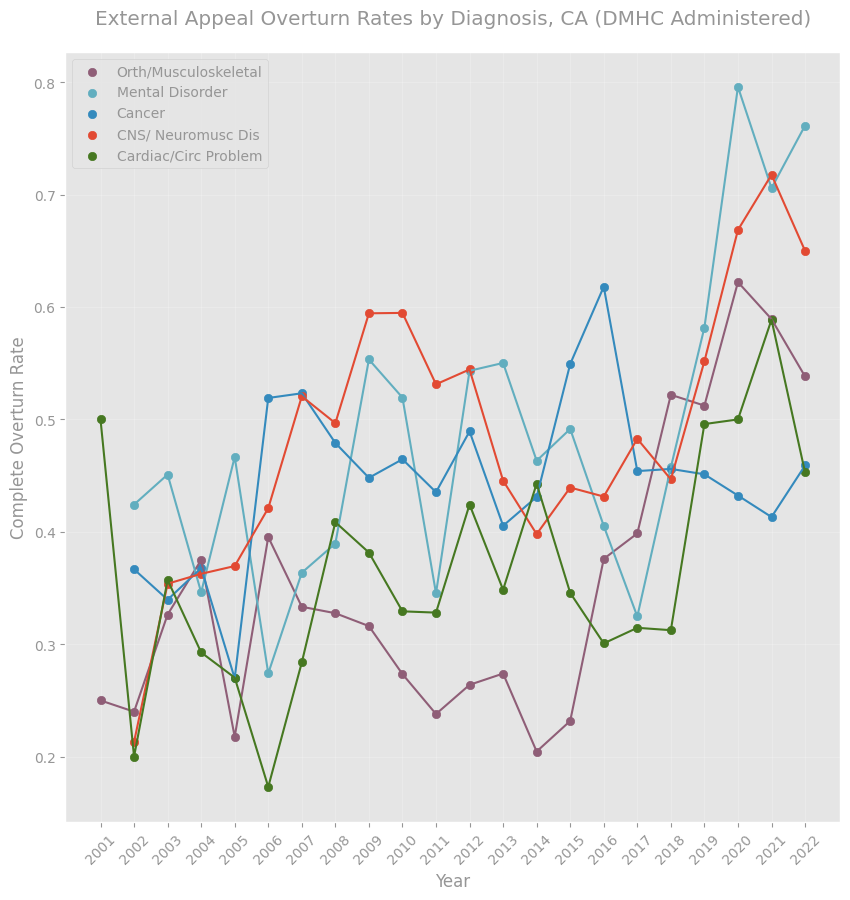

In [56]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df,
    outcome_col="Determination",
    cat_col=diagnosis_cat_name,
    by_year=True,
    upheld_cat_name=uphold_cat_name,
    overturned_cat_name=overturn_cat_name,
    year_cat_name=year_cat_name,
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[year_cat_name].unique())
ax.set_title("External Appeal Overturn Rates by Diagnosis, CA (DMHC Administered)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(diagnosis_decision_data[diagnosis][year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend(loc="upper left")
ax.set_xticklabels(dates, rotation=45)
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

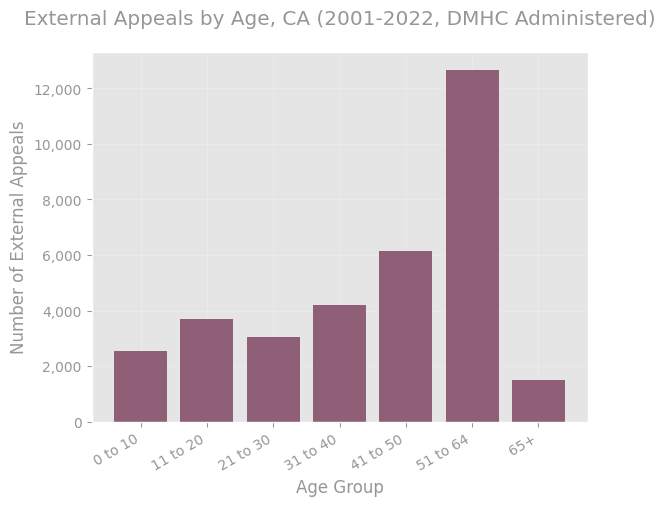

In [57]:
appeals_by_age = df["AgeRange"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeals by Age, CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)

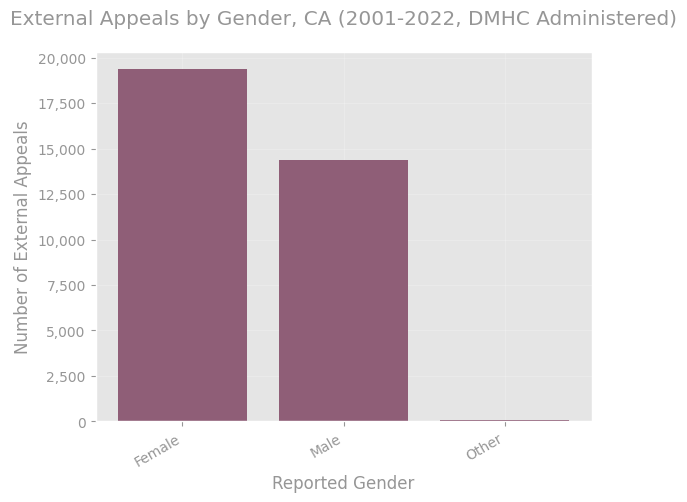

In [58]:
appeals_by_age = df["PatientGender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeals by Gender, CA (2001-2022, DMHC Administered)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)